<a href="https://colab.research.google.com/github/JWoinski/PracaDyp/blob/main/Clustering_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import sklearn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

11501568/11490434 [==============================] - 0s 0us/step
Training: (60000, 28, 28)
Test: (10000, 28, 28)


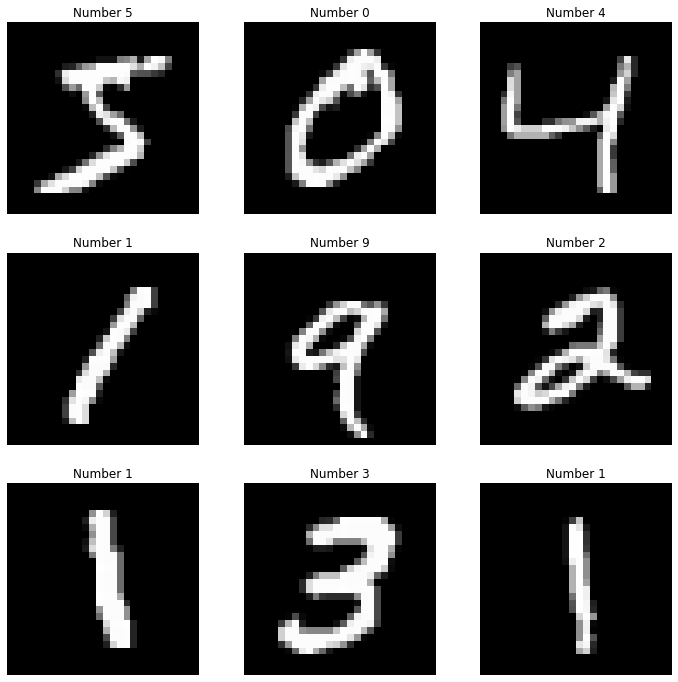

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Print shape of dataset
print("Training: {}".format(X_train.shape))
print("Test: {}".format(X_test.shape))
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.imshow(X_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
    
# display the figure
plt.show()

In [3]:
# Convert each image to 1d array (28x28 -> 784x1)
X_train = X_train.reshape(len(X_train), -1)
print(X_train.shape)

(60000, 784)


In [4]:
# Normalize the data to 0 - 1
X_train = X_train.astype(np.float32) / 255.

In [5]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(y_train))
print(n_digits)

10


In [6]:
kmeans = MiniBatchKMeans(n_clusters=n_digits)
kmeans.fit(X_train)

MiniBatchKMeans(n_clusters=10)

In [7]:
kmeans.labels_

array([7, 5, 3, ..., 7, 1, 6], dtype=int32)

In [8]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    # Loop through the clusters
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [9]:
cluster_labels = infer_cluster_labels(kmeans, y_train)
X_clusters = kmeans.predict(X_train)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(y_train[:20])

[5 0 4 1 9 2 1 3 1 9 3 1 3 6 1 7 2 1 5 1]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [10]:
from sklearn.metrics import homogeneity_score

def calc_metrics(estimator, data, labels):
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    # Inertia
    inertia = estimator.inertia_
    print("Inertia: {}".format(inertia))
    # Homogeneity Score
    homogeneity = homogeneity_score(labels, estimator.labels_)
    print("Homogeneity score: {}".format(homogeneity))
    return inertia, homogeneity

In [11]:
from sklearn.metrics import accuracy_score

clusters = [10, 16, 36, 64, 144, 256]
iner_list = []
homo_list = []
acc_list = []

for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters=n_clusters)
    estimator.fit(X_train)
    
    inertia, homo = calc_metrics(estimator, X_train, y_train)
    iner_list.append(inertia)
    homo_list.append(homo)
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, y_train)
    prediction = infer_data_labels(estimator.labels_, cluster_labels)
    
    acc = accuracy_score(y_train, prediction)
    acc_list.append(acc)
    print('Accuracy: {}\n'.format(acc))

Number of Clusters: 10
Inertia: 2387001.0
Homogeneity score: 0.48927882496423647
Accuracy: 0.5893

Number of Clusters: 16
Inertia: 2223464.0
Homogeneity score: 0.5335224581947059
Accuracy: 0.6083833333333334

Number of Clusters: 36
Inertia: 1966749.125
Homogeneity score: 0.6608195865380646
Accuracy: 0.7310833333333333

Number of Clusters: 64
Inertia: 1811200.0
Homogeneity score: 0.7451922375811659
Accuracy: 0.8238333333333333

Number of Clusters: 144
Inertia: 1621172.75
Homogeneity score: 0.8097456224096533
Accuracy: 0.8765

Number of Clusters: 256
Inertia: 1500328.875
Homogeneity score: 0.845649188913626
Accuracy: 0.9017333333333334



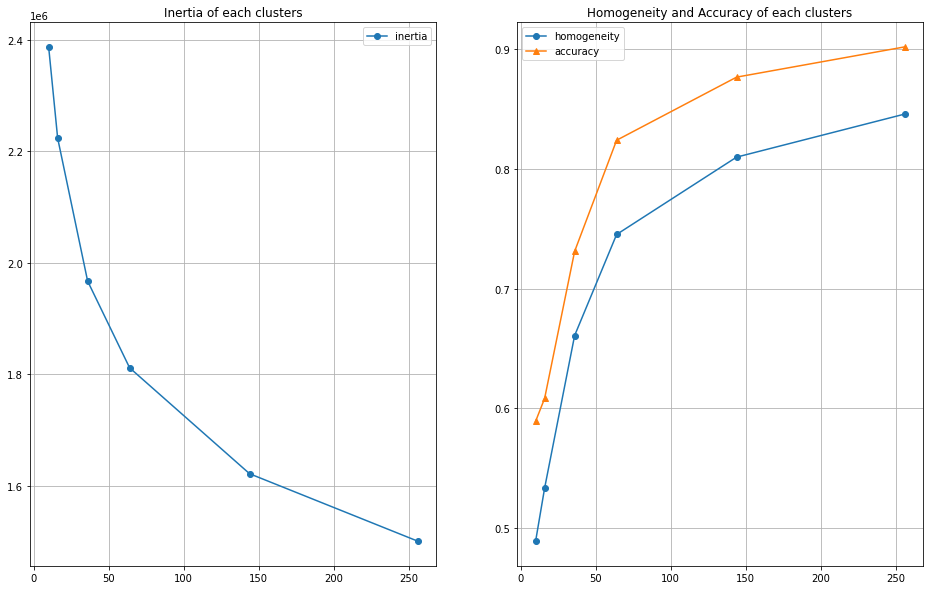

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].plot(clusters, iner_list, label='inertia', marker='o')
ax[1].plot(clusters, homo_list, label='homogeneity', marker='o')
ax[1].plot(clusters, acc_list, label='accuracy', marker='^')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].grid('on')
ax[1].grid('on')
ax[0].set_title('Inertia of each clusters')
ax[1].set_title('Homogeneity and Accuracy of each clusters')
plt.show()

In [13]:
X_test = X_test.reshape(len(X_test), -1)
X_test = X_test.astype(np.float32) / 255.

kmeans = MiniBatchKMeans(n_clusters=256)
kmeans.fit(X_test)

cluster_labels = infer_cluster_labels(kmeans, y_test)

test_clusters = kmeans.predict(X_test)
prediction = infer_data_labels(kmeans.predict(X_test), cluster_labels)
print('Accuracy: {}'.format(accuracy_score(y_test, prediction)))

Accuracy: 0.8964


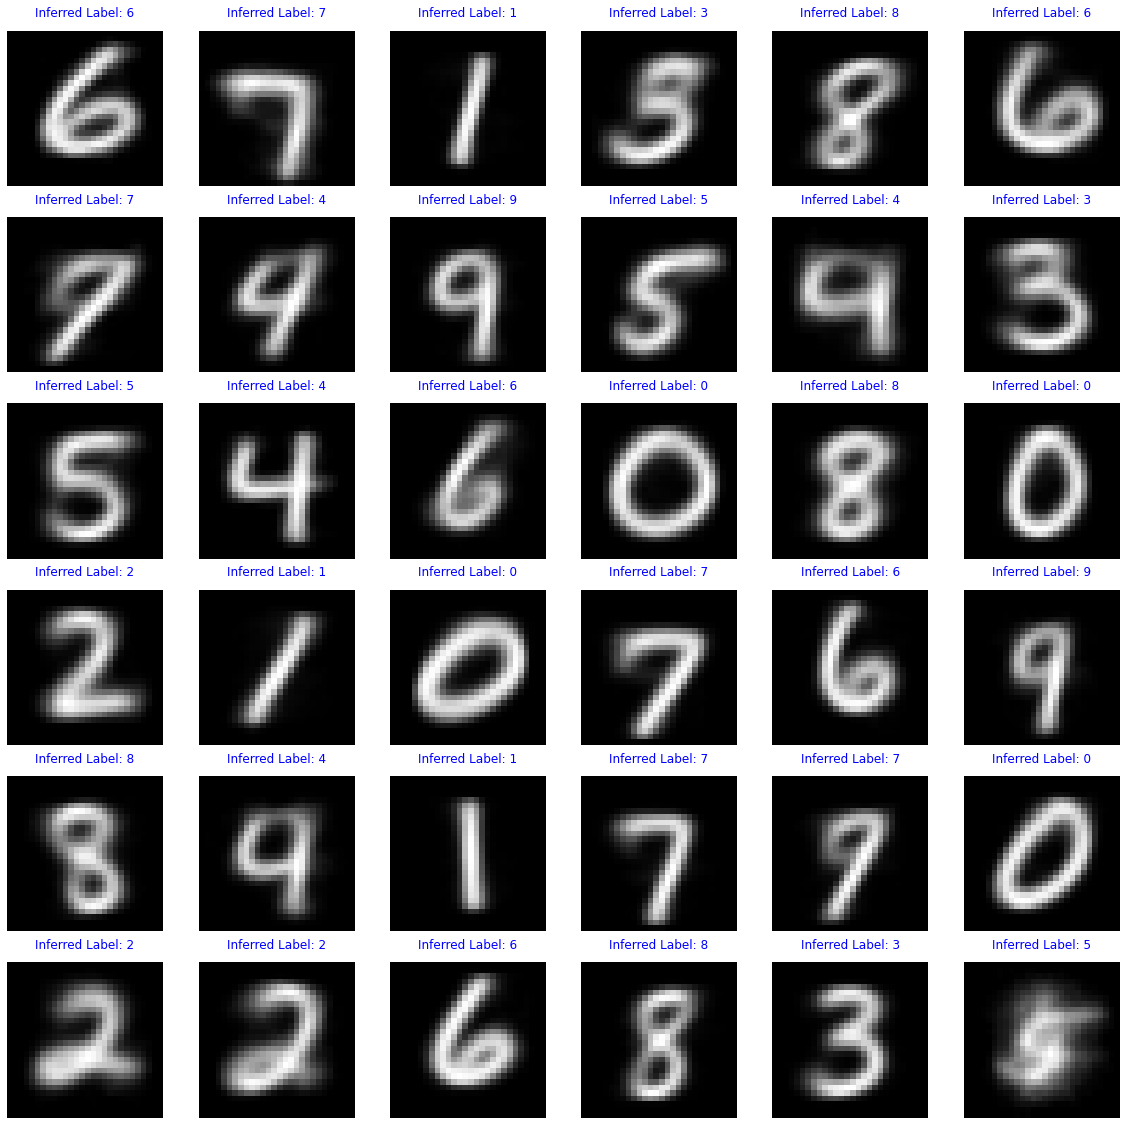

In [14]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X_test)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, y_test)
prediction = infer_data_labels(kmeans.predict(X_test), cluster_labels)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():        
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key), color='blue')
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
plt.show()